In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, LeakyReLU, Activation, BatchNormalization, Dropout, Reshape, Flatten
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [ ]:
num_classes = 10

In [ ]:
X_train = X_train.astype('float32') / 255.0
X_train = X_train.astype('float32') / 255.0

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [ ]:
X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


```
input_shape = (28,28,1)
encoder_conv_filters = [32,64,64,64]
encoder_kernel_size = [3,3,3,3]
encoder_strides = [1,2,2,1]
z_dim = 2

decoder_conv_t_filters = [64,64,32,1]
decoder_conv_t_kernel_size = [3,3,3,3]
decoder_strides = [1,2,2,1]
```

In [ ]:
# encoder
encoder_input = Input(shape=input_shape, name='encoder_input')

x = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# from keras import backend as K
# K.int_shape(x) == x.shape
save_shape = x.shape
x = Flatten()(x)

encoder_output = Dense(2, name='encoder_output')(x)

encoder = Model(encoder_input, encoder_output)
encoder.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_57 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_57 (LeakyReLU)  (None, 28, 28, 32)        0         
                                                                 
 conv2d_40 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_58 (Bat  (None, 14, 14, 64)       256       
 chNormalization)                                         

In [ ]:
print(save_shape)

(None, 7, 7, 64)


In [ ]:
# decoder
decoder_input = Input(shape=(2), name="decoder_input")

x = Dense(np.prod(save_shape[1:]))(decoder_input)
x = Reshape(save_shape[1:])(x)

x = Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Activation('sigmoid')(x)
decoder_output = x

decoder = Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_9 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 7, 7, 64)         36928     
 Transpose)                                                      
                                                                 
 batch_normalization_61 (Bat  (None, 7, 7, 64)         256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_61 (LeakyReLU)  (None, 7, 7, 64)          0  

In [ ]:
model_input = encoder_input
model_output = decoder(encoder_output)
model = Model(model_input, model_output)

In [ ]:
model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_57 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_57 (LeakyReLU)  (None, 28, 28, 32)        0         
                                                                 
 conv2d_40 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_58 (Bat  (None, 14, 14, 64)       256       
 chNormalization)                                         

In [ ]:
model.compile(
    loss = 'mse',
    optimizer = Adam(learning_rate=0.0005)
)

In [ ]:
model.fit(
    X_train,
    X_train,
    batch_size = 32,
    epochs = 50
)

Epoch 1/50
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0062
Epoch 2/50
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0042
Epoch 3/50
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0028
Epoch 4/50
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0019
Epoch 5/50
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0013
Epoch 6/50
1875/1875 [==============================] - 14s 8ms/step - loss: 9.0059e-04
Epoch 7/50
1875/1875 [==============================] - 14s 8ms/step - loss: 5.5315e-04
Epoch 8/50
1875/1875 [==============================] - 14s 8ms/step - loss: 3.4831e-04
Epoch 9/50
1875/1875 [==============================] - 15s 8ms/step - loss: 2.2412e-04
Epoch 10/50
1875/1875 [==============================] - 15s 8ms/step - loss: 1.4541e-04
Epoch 11/50
1875/1875 [==============================] - 14s 8ms/step - loss: 9.2605e-05
Epoch 12/50
1875/1875 [===========================

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#이미지
image = encoder.predict(X_train)

In [ ]:
image.shape, y_train.shape

((60000, 2), (60000,))

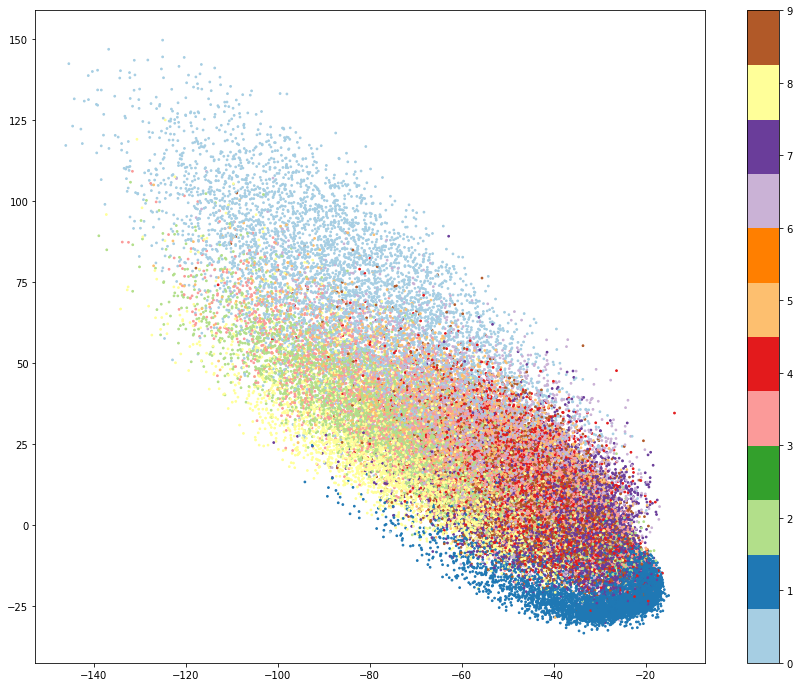

In [ ]:
plt.figure(figsize=(15, 12))
plt.scatter(x=image[:, 0], y=image[:, 1], c=y_train, cmap=plt.get_cmap('Paired'), s=3)
plt.colorbar()
plt.show()

In [ ]:
decoded_images = model.predict(X_train)

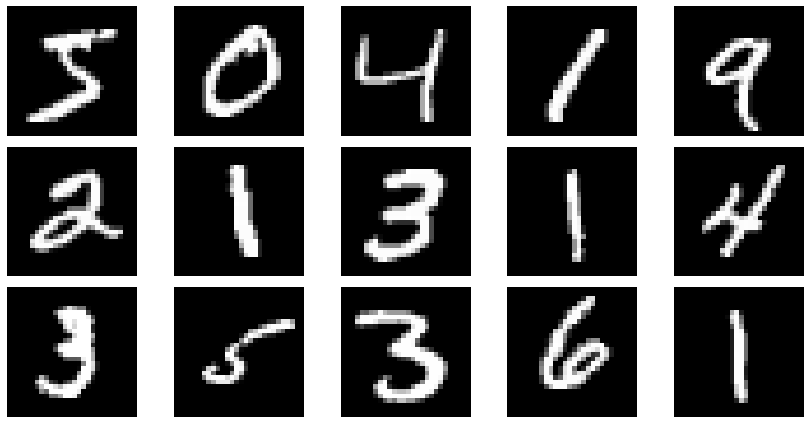

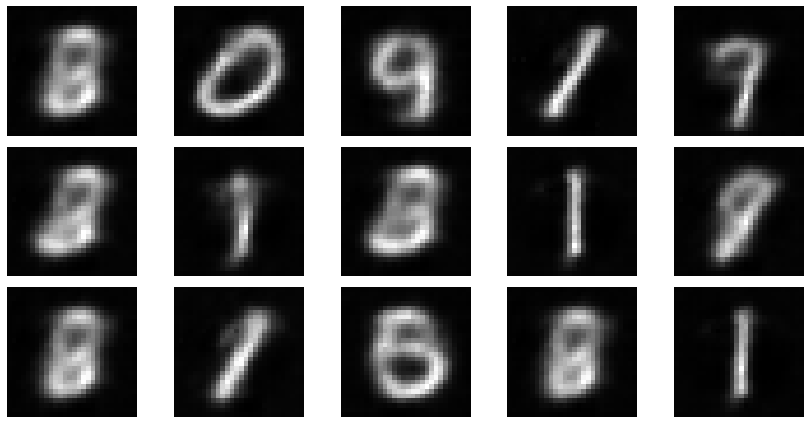

In [ ]:
fig, axes = plt.subplots(3, 5)
fig.set_size_inches(12, 6)
for i in range(15):
    axes[i//5, i%5].imshow(X_train[i].reshape(28, 28), cmap='gray')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 5)
fig.set_size_inches(12, 6)
for i in range(15):
    axes[i//5, i%5].imshow(decoded_images[i].reshape(28, 28), cmap='gray')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
model.fit(
    X_train,
    X_train,
    batch_size = 32,
    epochs = 100
)

Epoch 1/100
1875/1875 [==============================] - 16s 8ms/step - loss: 0.2181
Epoch 2/100
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1603
Epoch 3/100
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1152
Epoch 4/100
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0819
Epoch 5/100
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0577
Epoch 6/100
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0402
Epoch 7/100
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0280
Epoch 8/100
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0191
Epoch 9/100
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0131
Epoch 10/100
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0089
Epoch 11/100
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0062
Epoch 12/100
1875/1875 [==============================] - 15s 8

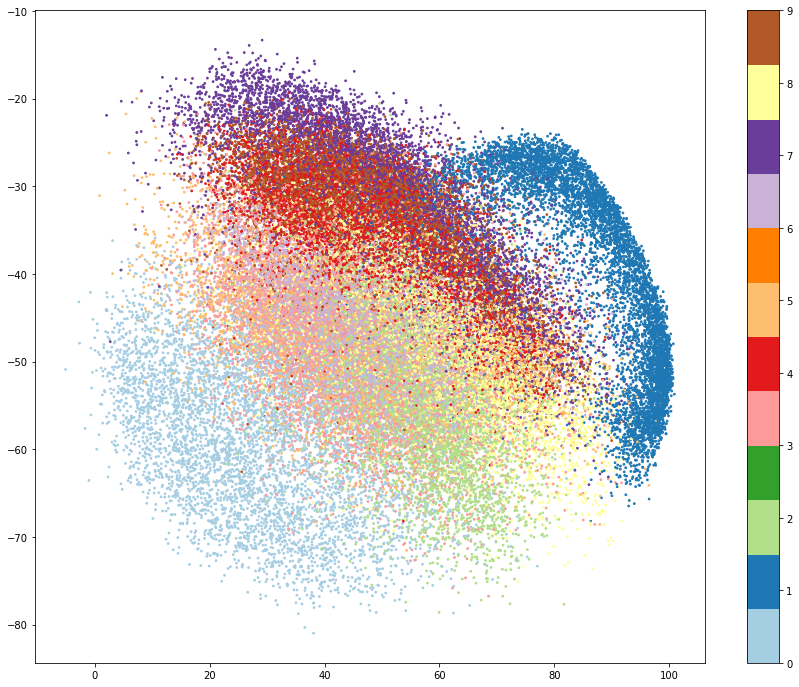

In [ ]:
image = encoder.predict(X_train)
plt.figure(figsize=(15, 12))
plt.scatter(x=image[:, 0], y=image[:, 1], c=y_train, cmap=plt.get_cmap('Paired'), s=3)
plt.colorbar()
plt.show()

In [ ]:
decoded_images = model.predict(X_train)

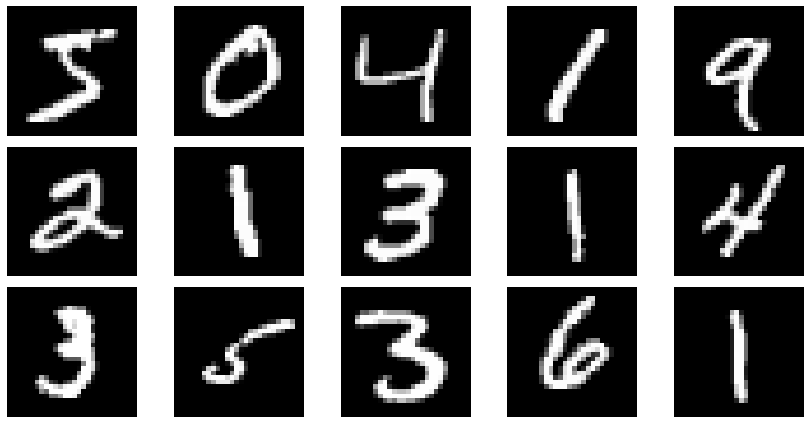

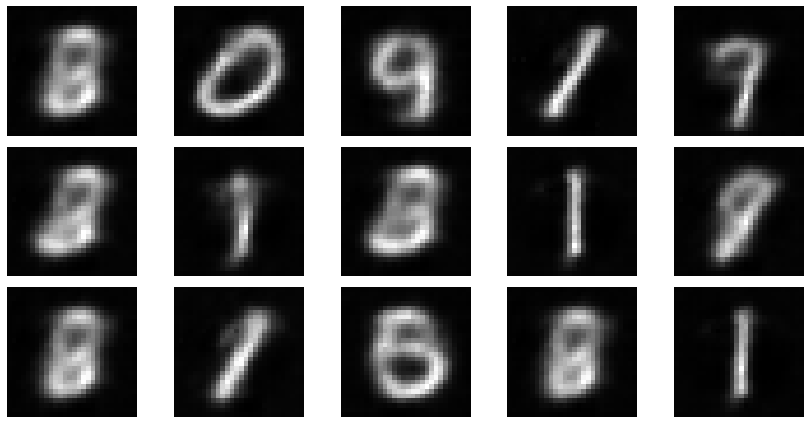

In [ ]:
fig, axes = plt.subplots(3, 5)
fig.set_size_inches(12, 6)
for i in range(15):
    axes[i//5, i%5].imshow(X_train[i].reshape(28, 28), cmap='gray')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 5)
fig.set_size_inches(12, 6)
for i in range(15):
    axes[i//5, i%5].imshow(decoded_images[i].reshape(28, 28), cmap='gray')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()